In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import pltdist, plotfitresult, plotlimit

import zfit
from zfit.loss import UnbinnedNLL
from zfit.minimize import Minuit

from hepstats.hypotests.calculators import AsymptoticCalculator, FrequentistCalculator
from hepstats.hypotests import UpperLimit, Discovery
from hepstats.hypotests.parameters import POI, POIarray

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit/util/execution.py:70: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [2]:
Nsig = zfit.Parameter("Nsig", 0, -100., 100)
Nbkg = zfit.Parameter("Nbkg", 100, 0, 500)

In [3]:
Nobs = zfit.ComposedParameter("Nobs", lambda a, b: a + b, params=[Nsig, Nbkg])

In [5]:
# Poisson PDF is not yet availabe in zfit, see https://github.com/zfit/zfit/pull/264

from zfit.models.dist_tfp import WrapDistribution
import tensorflow_probability as tfp
from zfit.util import ztyping
from collections import OrderedDict


class Poisson(WrapDistribution):
    _N_OBS = 1

    def __init__(self,
                 lamb: ztyping.ParamTypeInput,
                 obs: ztyping.ObsTypeInput,
                 name: str = "Poisson"):
        """
        Poisson distribution, parametrized with an event parameter (lamb).
        """
        (lamb,) = self._check_input_params(lamb)
        params = OrderedDict((('lamb', lamb),))
        dist_params = dict(rate=lamb)
        distribution = tfp.distributions.Poisson
        super().__init__(distribution=distribution, dist_params=dist_params,
                         obs=obs, params=params, name=name)

In [6]:
obs = zfit.Space('N', limits=(0, 800))

In [7]:
model = Poisson(obs=obs, lamb=Nobs)

In [8]:
Nbkg.set_value(339)
Nbkg.floating = False

In [9]:
data = zfit.data.Data.from_numpy(obs=obs, array=np.array([369]))

In [10]:
nll = UnbinnedNLL(model=model, data=data)

In [11]:
nll.value()

<tf.Tensor: shape=(), dtype=float64, numpy=5.1644847183293905>

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


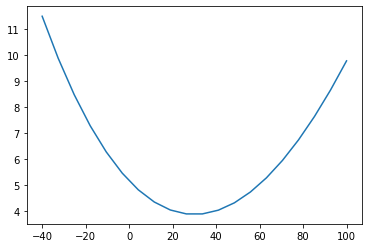

In [12]:
pts = np.linspace(-40, 100, 20)
values = []

for p in pts:
    with Nsig.set_value(p):
        values.append(nll.value().numpy())
        
plt.plot(pts, values)

In [13]:
# Instantiate a minuit minimizer
minimizer = Minuit()

In [14]:
# minimisation of the loss function
minimum = minimizer.minimize(loss=nll)
minimum.hesse()
print(minimum)

------------------------------------------------------------------
| FCN = 3.875                   |      Ncalls=20 (20 total)      |
| EDM = 5.84e-08 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
FitResult of
<UnbinnedNLL model=[<zfit.Poisson  params=[Nobs] dtype=float64>0] data=[<zfit.core.data.Data object at 0x7f9f39a3c050>] constraints=[]> 
with
<Minuit strategy=PushbackStrategy toleran

In [15]:
# instantation of the calculator
#calculator = FrequentistCalculator(nll, minimizer, ntoysnull=1000, ntoysalt=1000)
calculator = AsymptoticCalculator(nll, minimizer, asimov_bins=100)
calculator.bestfit = minimum #optionnal

In [16]:
# parameter of interest of the null hypothesis
poinull = POIarray(Nsig, np.linspace(0.0, 100, 20))
# parameter of interest of the alternative hypothesis
poialt = POI(Nsig, 0)

In [17]:
discovery_test = Discovery(calculator, POI(Nsig, 0))
pnull, significance = discovery_test.result()


p_value for the Null hypothesis = 0.054116166221466644
Significance (in units of sigma) = 1.6061892598241103


In [18]:
# instantation of the discovery test
ul = UpperLimit(calculator, poinull, poialt)
ul.upperlimit(alpha=0.05, CLs=False);


Get fitted values of the nuisance parameters for the alternative hypothesis!
VALUUUUUUUUES <class 'dict'> {<zfit.Parameter 'Nsig' floating=False value=29.99>: {'value': 0}}


/Users/matthieumarinangeli/hepstats/src/hepstats/hypotests/calculators/asymptotic_calculator.py:34: UserWarning: The function <function Space.limit1d at 0x7f9f381098c0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('N',), axes=(0,), limits=(array([[0.]]), array([[800.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  bounds = space.limit1d
/Users/matthieumarinangeli/hepstats/src/hepstats/hypotests/calculators/asymptotic_calculator.py:39: UserWarning: The function <function Space.area at 0x7f9f38109680> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('N',), axes=(0,), limits=(array([[0.]]), array([[800.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  hist *= space.area() / nbins
/Us


Observed upper limit: Nsig = 62.50490651401164
Expected upper limit: Nsig = 31.193516192269385
Expected upper limit +1 sigma: Nsig = 51.05615255026214
Expected upper limit -1 sigma: Nsig = 12.011185508727886
Expected upper limit +2 sigma: Nsig = 71.6083877127078
Expected upper limit -2 sigma: Nsig = None


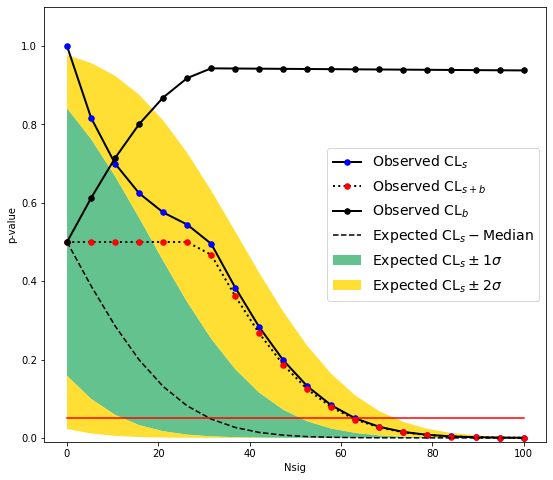

In [19]:
f = plt.figure(figsize=(9, 8))
plotlimit(ul, alpha=0.05, CLs=False)
plt.xlabel("Nsig");